In [1]:
import numpy as np
import pandas as pd
import os
import warnings

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import joblib

# Suppress warnings
warnings.filterwarnings('ignore')

In [6]:
def load_data(project_path):
    """
    Load network intrusion detection datasets from multiple days
    """
    print("1. Loading Data...")
    days = ['friday']
    dfs = []
    
    for day in days:
        file_path = os.path.join(project_path, 'data', 'cicids2017', f'{day}.csv')
        print(f"   Loading data for {day}: {file_path}")
        df = pd.read_csv(file_path)
        dfs.append(df)
    
    full_df = pd.concat(dfs, ignore_index=True)
    print(f"   Total records loaded: {len(full_df)}")
    print(f"   Columns in dataset: {list(full_df.columns)}\n")
    
    return full_df

def preprocess_data(project_path, full_df):
    """
    Preprocess the dataset by cleaning, transforming, and preparing features
    """
    print("2. Data Preprocessing...")
    
    # Clean Column Names
    full_df.columns = full_df.columns.str.strip()
    
    # Convert Timestamp
    full_df['Timestamp'] = pd.to_datetime(full_df['Timestamp'])
    full_df = full_df.sort_values(by='Timestamp').reset_index(drop=True)

    # Filter Label
    print("   Filtering labels...")
    categories = [
        "BENIGN", "DDoS", "DoS Slowloris", "DoS Slowhttptest", "DoS Hulk", 
        "DoS GoldenEye", "Heartbleed", "Portscan", "Botnet", "FTP-Patator", 
        "SSH-Patator", "Web Attack - Brute Force", "Web Attack - XSS",
        "Web Attack - SQL Injection", "Infiltration"
    ]
    full_df = full_df[full_df['Label'].isin(categories)]
    
    # Feature Selection: Drop irrelevant columns
    irrelevant_columns = ["id", "Flow ID", "Attempted Category", "Timestamp",
                          "Src IP", "Dst IP", 'Hour', 'Day']
    full_df.drop(columns=irrelevant_columns, axis=1, inplace=True, errors='ignore')
    
    # Handle Missing Values
    print("   Handling missing values...")
    full_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    full_df.dropna(axis=0, how='any', inplace=True)
    
    # Encode Labels
    print("   Encoding labels...")
    label_col = 'Label'
    label_encoder_path = os.path.join(project_path, 'models', 'label_encoder.pkl')
    label_encoder = joblib.load(label_encoder_path)
    full_df['Label_Enc'] = label_encoder.transform(full_df[label_col])
    
    print("   Unique labels:", label_encoder.classes_)
    print("   Label distribution:")
    label_dist = full_df['Label'].value_counts()
    print(label_dist)
    print(f"   Records after preprocessing: {len(full_df)}\n")
    
    return full_df, label_encoder, label_dist

def inference_and_evaluate(project_path):
    """
    Load the saved model and scaler, perform inference on the whole dataset, and compute accuracy
    """
    print("\n--- Inference and Evaluation ---")
    
    # Paths
    models_dir = os.path.join(project_path, 'models')
    model_path = os.path.join(models_dir, 'xgb_classifier.pkl')
    scaler_path = os.path.join(models_dir, 'scaler.pkl')

    # Check if model and scaler exist
    if not os.path.exists(model_path):
        print(f"Error: Model file not found at '{model_path}'")
        return
    if not os.path.exists(scaler_path):
        print(f"Error: Scaler file not found at '{scaler_path}'")
        return
    
    # Load the model and scaler
    print("1. Loading Model, Scaler, and Label Encoder...")
    loaded_model = joblib.load(model_path)
    loaded_scaler = joblib.load(scaler_path)
    print("   Model, scaler, and label encoder loaded successfully.")
    
    # Load Data
    print("2. Loading Data...")
    full_df = load_data(project_path)
    
    # Preprocess Data
    print("3. Preprocessing Data...")
    full_df, label_encoder, label_dist = preprocess_data(project_path=project_path, full_df=full_df)
    
    # Prepare Features
    print("4. Preparing Features...")
    feature_cols = pd.read_csv(os.path.join(project_path, 'src', 'netviser', 'features.csv'))['Feature'].tolist()[:10]
    
    # Verify that all required features are present
    missing_features = set(feature_cols) - set(full_df.columns)
    if missing_features:
        print(f"Error: The following required features are missing from the dataset: {missing_features}")
        return
    
    X = full_df[feature_cols]
    y = full_df['Label_Enc']
    
    # Feature Scaling using the loaded scaler
    print("   Scaling features using the loaded scaler...")
    X_scaled = loaded_scaler.transform(X)
    
    # Make Predictions
    print("5. Making Predictions...")
    y_pred = loaded_model.predict(X_scaled)
    
    # Compute Accuracy
    print("6. Computing Accuracy...")
    accuracy = accuracy_score(y, y_pred)
    print(f"   Accuracy on the entire dataset: {accuracy:.4f}")

    # Compute F1 Score
    print("   F1 Score:")
    print(f"   F1 Score on the entire dataset: {f1_score(y, y_pred=y_pred, average='weighted'):.4f}")
    
    # Classification Report
    print("\n   Classification Report:")
    print(classification_report(y, y_pred))
    
    # Confusion Matrix Visualization
    print("7. Generating Confusion Matrix...")
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='g', cmap='YlGnBu',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for XGBoost Classifier')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return accuracy



--- Inference and Evaluation ---
1. Loading Model, Scaler, and Label Encoder...
   Model, scaler, and label encoder loaded successfully.
2. Loading Data...
1. Loading Data...
   Loading data for friday: /Users/supakrit-a/Code/netviser/data/cicids2017/friday.csv
   Total records loaded: 547557
   Columns in dataset: ['id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bw

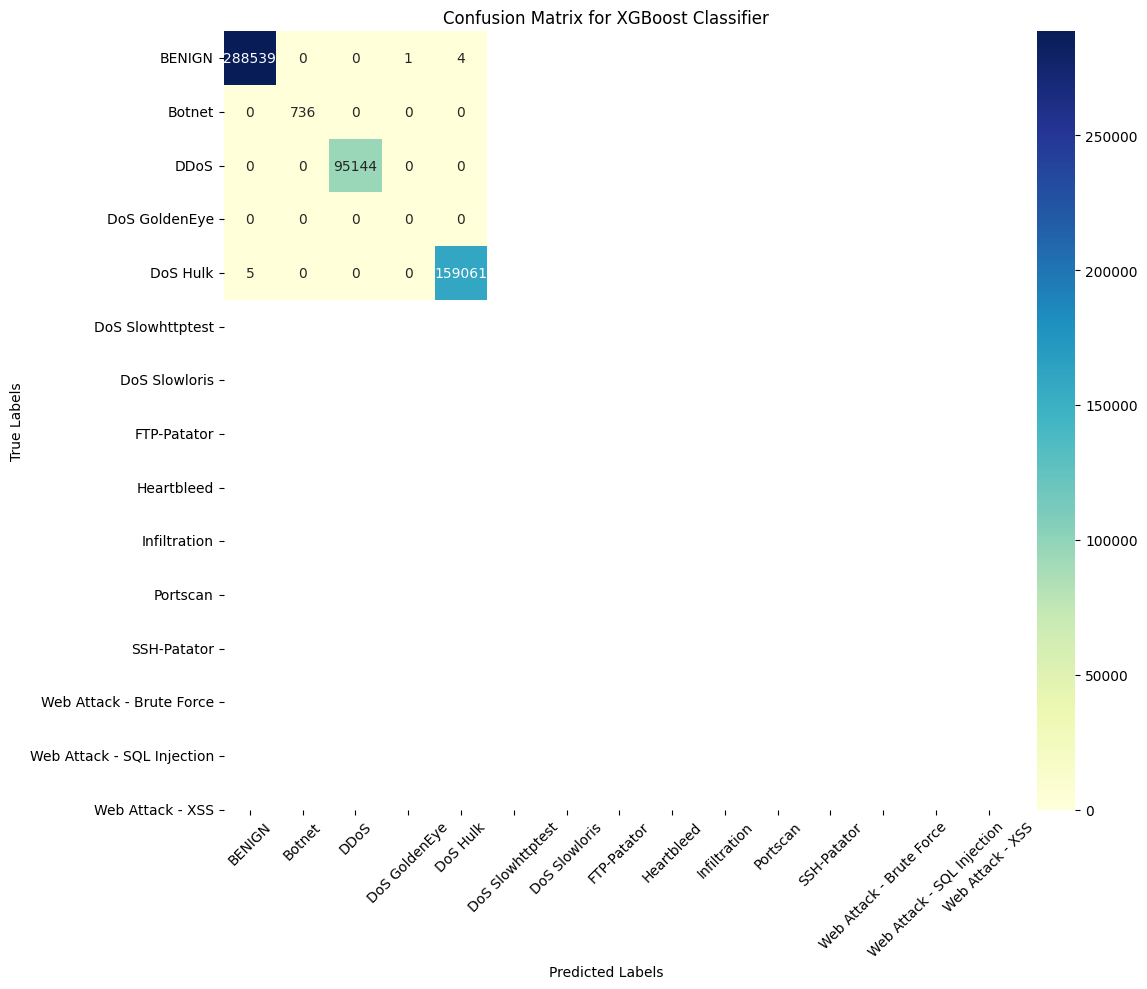


Final Accuracy: 1.0000


In [7]:
project_path = '/Users/supakrit-a/Code/netviser'

# Perform inference and evaluate
accuracy = inference_and_evaluate(project_path)
print(f"\nFinal Accuracy: {accuracy:.4f}")